# Load and imports

In [1]:
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h2o

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
from h2o.automl import H2OAutoML

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

df05ht = pd.read_csv('data_live_scores_full.csv', encoding='utf-8')
print(df05ht.shape)

(1155173, 37)


In [2]:
df05ht

,date,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,crossesHome,crossesAway,...,fouls_c_home,fouls_c_away,fouls_won_home,fouls_won_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id
0,2020-01-09,90+4:21,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
1,2020-01-09,90+3:42,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
2,2020-01-09,90+3:02,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
3,2020-01-09,90+2:23,FC Barcelona,Club Atlético de Madrid,2.0,3.0,15.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
4,2020-01-09,90+1:44,FC Barcelona,Club Atlético de Madrid,2.0,3.0,15.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,12.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155168,2023-11-28,2:42,Ross County FC,Saint Mirren FC,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,2023-11-28-Ross County FC-Saint Mirren FC
1155169,2023-11-28,2:03,Ross County FC,Saint Mirren FC,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-11-28-Ross County FC-Saint Mirren FC
1155170,2023-11-28,1:24,Ross County FC,Saint Mirren FC,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-11-28-Ross County FC-Saint Mirren FC
1155171,2023-11-28,0:45,Ross County FC,Saint Mirren FC,0.0,NaN,0.0,NaN,1.0,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0,2023-11-28-Ross County FC-Saint Mirren FC


In [3]:
date_object = pd.to_datetime(df05ht['date'], format='%Y-%m-%d')

min_date = date_object.min()
max_date = date_object.max()

print("Os dados vão de {} até {}".format(min_date, max_date))

Os dados vão de 2020-01-08 00:00:00 até 2023-12-01 00:00:00


In [4]:
df05ht.columns

Index(['date', 'minute', 'homeTeam', 'awayTeam', 'goalHome', 'goalAway',
       'shotsHome', 'shotsAway', 'crossesHome', 'crossesAway', 'assistsHome',
       'assistsAway', 'blockedShotsHome', 'blockedShotsAway', 'league',
       'corners_home', 'corners_away', 'redcards_home', 'redcards_away',
       'shotsOffgoal_home', 'shotsOffgoal_away', 'shotsOngoal_home',
       'shotsOngoal_away', 'yellowcards_home', 'yellowcards_away',
       'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away',
       'fouls_won_home', 'fouls_won_away', 'offsides_home', 'offsides_away',
       'tackles_home', 'tackles_away', 'result', 'match_id'],
      dtype='object')

# Analisando e tratando os dados

## Limpeza

In [5]:
df = df05ht.copy()
print(f'Dimensão do DataFrame antes remoção: {df05ht.shape}')
print(f'Valores únicos de minutos antes da conversão: {df05ht.minute.unique()} \n')
registros_duplicados = len(df05ht[df05ht.duplicated()])
print(f'Registros duplicados: {registros_duplicados}')
df.drop_duplicates(keep='last', inplace=True)

registros_nulos = df.isnull().sum().sum()
print(f'Registros nulos: {registros_nulos}\n')
df.dropna(inplace=True)

# Convertendo os minutos para inteiros
df['minute_converted'] = df05ht['minute'].str.extract('(\d+)').astype(int)

# Removendo os minutos iguais a 0
df = df[df['minute_converted'] != 0]

# removendo minutos > 45
df = df[df['minute_converted'] <= 45]

df['minute'] = df['minute_converted']
df.drop(columns=['minute_converted'], inplace=True)
# print(f'Jogos que serão retirados: {len(invalid_ids)}\n')

print(f'Dimensão do DataFrame após remoção: {df.shape}')
print(f'Total de registros retirados: {df05ht.shape[0] - df.shape[0]}')

Dimensão do DataFrame antes remoção: (1155173, 37)
Valores únicos de minutos antes da conversão: ['90+4:21' '90+3:42' '90+3:02' ... '33:55' '16:47' '5:22'] 

Registros duplicados: 70
Registros nulos: 39570

Dimensão do DataFrame após remoção: (566300, 37)
Total de registros retirados: 588873


In [6]:
df_copy = df.copy()

In [35]:
df = df_copy.copy()

janela_tempo = 10
df.sort_values(by=['match_id', 'minute'], inplace=True) # ordenando por match_id e minuto

# definindo janela de tempo após acontecimento do evento (gol casa ou fora)
df_not_goal = df[(df['goalHome'] == 0) & (df['goalAway'] == 0)] # dataframe sem gol
df_goal = df[df['goalHome'] + df['goalAway'] == 1].head(1) # dataframe com a primeira ocorrencia do evento (gol)

df = pd.concat([df_not_goal, df_goal], axis=0)

# adicionar a cada match_id (partida) os ultimos 10 registros antes do gol 1 a coluna result
for match_id in df['match_id'].unique():
    last_10 = df[df['match_id'] == match_id].tail(janela_tempo)

    # Atualize a coluna 'result' para 1 nesses registros
    df.loc[last_10.index, 'result'] = 1

df.shape

(327815, 37)

In [8]:
df_trated = df.copy()

In [9]:
# df = df_trated

In [38]:
df[df['match_id'] == '2020-01-08-Valencia CF-Real Madrid CF'].tail(20) # exemplo de como ficou

,date,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,crossesHome,crossesAway,...,fouls_c_home,fouls_c_away,fouls_won_home,fouls_won_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id
14925,2020-01-08,3,Valencia CF,Real Madrid CF,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,2020-01-08-Valencia CF-Real Madrid CF
14926,2020-01-08,3,Valencia CF,Real Madrid CF,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,2020-01-08-Valencia CF-Real Madrid CF
14924,2020-01-08,4,Valencia CF,Real Madrid CF,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,2020-01-08-Valencia CF-Real Madrid CF
14922,2020-01-08,5,Valencia CF,Real Madrid CF,0.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,2020-01-08-Valencia CF-Real Madrid CF
14923,2020-01-08,5,Valencia CF,Real Madrid CF,0.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,2020-01-08-Valencia CF-Real Madrid CF
14920,2020-01-08,6,Valencia CF,Real Madrid CF,0.0,0.0,0.0,3.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0,2020-01-08-Valencia CF-Real Madrid CF
14921,2020-01-08,6,Valencia CF,Real Madrid CF,0.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0,2020-01-08-Valencia CF-Real Madrid CF
14919,2020-01-08,7,Valencia CF,Real Madrid CF,0.0,0.0,0.0,3.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0,2020-01-08-Valencia CF-Real Madrid CF
14917,2020-01-08,8,Valencia CF,Real Madrid CF,0.0,0.0,0.0,3.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,0,2020-01-08-Valencia CF-Real Madrid CF
14918,2020-01-08,8,Valencia CF,Real Madrid CF,0.0,0.0,0.0,3.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0,2020-01-08-Valencia CF-Real Madrid CF


## Seleção de Ligas, Cálculo de Posse de Bola e Limpeza do DataFrame

In [39]:
# Calculando o tempo de posse de bola
total_passes = df['passes_away'] + df['passes_home']
df['possessiontime_away'] = round((df['passes_away'] / total_passes) * 100)
df['possessiontime_home'] = round((df['passes_home'] / total_passes) * 100)

df['possessiontime_home'].fillna(method='bfill', inplace=True)
df['possessiontime_away'].fillna(method='bfill', inplace=True)

print("\nDados de posse de bola:\n", df[['possessiontime_away', 'possessiontime_home']].head())

# Renomeando colunas
new_column_names = {'fouls_won_away': 'fouls_away', 'fouls_won_home': 'fouls_home'}
df.rename(columns=new_column_names, inplace=True)
print("\nColunas renomeadas:\n", df.columns)

# Removendo colunas desnecessárias e limpando o DataFrame
columns_to_drop = ["date", 'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away','goalHome', 'goalAway', 'crossesHome', 'crossesAway', 'assistsHome',
       'assistsAway',]
df.drop(columns=columns_to_drop, inplace=True)
print("\nDataFrame após remover colunas:\n", df.columns)

df.reset_index(drop=True, inplace=True)
print(f'Dimensão do DataFrame após modificações: {df.shape}')
df.isnull().sum()


Dados de posse de bola:
        possessiontime_away  possessiontime_home
14928                 95.0                  5.0
14929                 93.0                  7.0
14927                 85.0                 15.0
14925                 86.0                 14.0
14926                 87.0                 13.0

Colunas renomeadas:
 Index(['date', 'minute', 'homeTeam', 'awayTeam', 'goalHome', 'goalAway',
       'shotsHome', 'shotsAway', 'crossesHome', 'crossesAway', 'assistsHome',
       'assistsAway', 'blockedShotsHome', 'blockedShotsAway', 'league',
       'corners_home', 'corners_away', 'redcards_home', 'redcards_away',
       'shotsOffgoal_home', 'shotsOffgoal_away', 'shotsOngoal_home',
       'shotsOngoal_away', 'yellowcards_home', 'yellowcards_away',
       'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away',
       'fouls_home', 'fouls_away', 'offsides_home', 'offsides_away',
       'tackles_home', 'tackles_away', 'result', 'match_id',
       'possessiontime_away', 'po

minute                 0
homeTeam               0
awayTeam               0
shotsHome              0
shotsAway              0
blockedShotsHome       0
blockedShotsAway       0
league                 0
corners_home           0
corners_away           0
redcards_home          0
redcards_away          0
shotsOffgoal_home      0
shotsOffgoal_away      0
shotsOngoal_home       0
shotsOngoal_away       0
yellowcards_home       0
yellowcards_away       0
fouls_home             0
fouls_away             0
offsides_home          0
offsides_away          0
tackles_home           0
tackles_away           0
result                 0
match_id               0
possessiontime_away    0
possessiontime_home    0
dtype: int64

## Tratando o formato das ligas para ligas existentes 

In [40]:
# Obtendo ligas únicas
leagues_opta = df['league'].unique()
print("Ligas únicas:", leagues_opta)

# Iterando através das ligas únicas
for league in leagues_opta:
    print("Liga atual:", league)

# Mapeamento de nomes de ligas
name_mapping = {
    'England - Premier League': 'England - Premier League',
    'Germany - Bundesliga': 'Germany - Bundesliga',
    'Spain - Primera División': 'Spain - La Liga',
    'France - Ligue 1': 'France - Ligue 1',
    'Italy - Serie A': 'Italy - Serie A',
    'USA - MLS': 'USA - Major League Soccer',
    'Brazil - Serie A': 'Brazil - Serie A',
    'Netherlands - Eredivisie': 'Netherlands - Eredivisie',
    'England - Championship': 'England - Championship',
    'Portugal - Primeira Liga': 'Portugal - Liga Portugal',
    'Romania - Liga I': 'Romania - Liga 1',
    "World - FIFA Women's World Cup": 'World - World Cup Women',
    'England - League One': 'England - League One',
    'England - League Two': 'England - League Two',
    'Europe - UEFA Europa Conference League': 'Europe - Europa Conference League',
    'England - League Cup': 'England - Carabao Cup',
    'Europe - UEFA Super Cup': 'Europe - Uefa Super Cup',
    'Europe - UEFA Champions League': 'Europe - Champions League',
    'Germany - DFB Pokal': 'Germany - DFB Pokal',
    'Italy - Coppa Italia': 'Italy - Coppa Italia',
    'Scotland - Premiership': 'Scotland - Premiership',
    'Germany - Super Cup': 'Germany - Super Cup',
    'South America - CONMEBOL Libertadores': 'South America - Copa Libertadores',
    'England - Community Shield': 'England - Community Shield',
    'N/C America - Concacaf Gold Cup': 'World - CONCACAF Gold Cup',
    'Europe - UEFA U21 Championship': 'Europe - Euro U21',
    'Australia - A-League Men': 'Australia - A-League',
    'Portugal - Play-offs 1/2': 'Portugal - Primeira Liga - Play-offs',
    'Europe - UEFA European Championship Qualifiers': 'Europe - Euro Qualification',
    'Germany - Play-offs 1/2': 'Germany - Bundesliga Play-offs',
    'Europe - UEFA Nations League': 'Europe - UEFA Nations League',
    'Europe - UEFA Europa League': 'Europe - Europa League',
    'England - FA Cup': 'England - FA Cup',
    'Spain - Copa del Rey': 'Spain - Copa Del Rey',
    'World - FIFA World Cup': 'World - FIFA World Cup',
    'France - Coupe de France': 'France - Coupe de France',
    'Spain - Super Cup': 'Spain - Super Cup',
    'Italy - Super Cup': 'Italy - Super Cup',
    'World - FIFA Club World Cup': 'World - FIFA Club World Cup',
    'Argentina - Liga Profesional Argentina': "Argentina - Superliga",
    'Brazil - Paulista A1': 'Brazil - Paulista A1',
    'Brazil - Copa do Brasil': 'Brazil - Copa Do Brasil',
    'Denmark - Superliga':'Denmark - Superliga',
    'Mexico - Liga MX': 'Mexico - Liga MX',
    'Greece - Super League 1': 'Greece - Super League',
    'Asia - AFC Champions League': 'Asia - AFC Champions League', 
    'South America - CONMEBOL Sudamericana': 'South America - Copa Sudamericana', 
    'Spain - Segunda División': 'Spain - La Liga 2',
    'Saudi Arabia - Saudi League': 'Saudi Arabia - Pro League',
    'Italy - Serie B': 'Italy - Serie B',
    'Japan - J1 League': 'Japan - J-League',
    'South America - CONMEBOL World Cup Qualifiers': 'World - WC Qualification South America',
    'Europe - UEFA World Cup Qualifiers': 'Europe - WC Qualification Europe', 
    "Europe - UEFA Women's Championship": "Europe - UEFA Women's EURO",
    "France - Trophée des Champions": 'France - Super Cup',
    'Brazil - Supercopa do Brasil': 'Brazil - Supercopa do Brasil',
    'South America - CONMEBOL Recopa': 'South America - Recopa Sudamericana',
    'Europe - UEFA European Championship': 'Europe - European Championship', 
    'N/C America - Leagues Cup': 'North & Central America - Leagues Cup',
    'South America - CONMEBOL Copa America': 'South America - Copa America',

}
print("\nTamanho do mapeamento de nomes de ligas:", len(name_mapping))

# Verificando o número de ligas únicas
print("Número de ligas únicas:", len(leagues_opta))
print("Número de ligas únicas após o mapeamento:", len(name_mapping))

# Atualizando os nomes das ligas no DataFrame
df['league'] = df['league'].replace(name_mapping)

# Verificando algumas linhas do DataFrame após a atualização dos nomes das ligas
# print("\nDataFrame após atualizar os nomes das ligas:\n", df['league'].unique())
for league in df['league'].unique():
    print("Liga atual no dataframe:", league)

Ligas únicas: ['Spain - Super Cup' 'South America - CONMEBOL Libertadores'
 'Asia - AFC Champions League' 'Brazil - Paulista A1'
 'South America - CONMEBOL Sudamericana' 'Brazil - Copa do Brasil'
 'Brazil - Supercopa do Brasil' 'South America - CONMEBOL Recopa'
 'Japan - J1 League' 'USA - MLS' 'Germany - Play-offs 1/2'
 'Mexico - Liga MX' 'Scotland - Premiership' 'Brazil - Serie A'
 'France - Ligue 1' 'Europe - UEFA Champions League'
 'England - Community Shield' 'England - League Cup'
 'Europe - UEFA Nations League' 'Greece - Super League 1'
 'Denmark - Superliga' 'Germany - DFB Pokal' 'England - Championship'
 'England - League One' 'England - League Two' 'England - Premier League'
 'Spain - Primera División' 'Netherlands - Eredivisie'
 'Spain - Segunda División' "Europe - UEFA Women's Championship"
 'Europe - UEFA Europa League' 'Germany - Bundesliga'
 'Portugal - Primeira Liga' 'Italy - Serie A' 'Europe - UEFA Super Cup'
 'Italy - Serie B' 'Germany - Super Cup'
 'South America - CO

Liga atual no dataframe: Spain - Super Cup
Liga atual no dataframe: South America - Copa Libertadores
Liga atual no dataframe: Asia - AFC Champions League
Liga atual no dataframe: Brazil - Paulista A1
Liga atual no dataframe: South America - Copa Sudamericana
Liga atual no dataframe: Brazil - Copa Do Brasil
Liga atual no dataframe: Brazil - Supercopa do Brasil
Liga atual no dataframe: South America - Recopa Sudamericana
Liga atual no dataframe: Japan - J-League
Liga atual no dataframe: USA - Major League Soccer
Liga atual no dataframe: Germany - Bundesliga Play-offs
Liga atual no dataframe: Mexico - Liga MX
Liga atual no dataframe: Scotland - Premiership
Liga atual no dataframe: Brazil - Serie A
Liga atual no dataframe: France - Ligue 1
Liga atual no dataframe: Europe - Champions League
Liga atual no dataframe: England - Community Shield
Liga atual no dataframe: England - Carabao Cup
Liga atual no dataframe: Europe - UEFA Nations League
Liga atual no dataframe: Greece - Super League
Li

## Balanceamento de Dados e Visualização da Distribuição de Resultados por Liga

Contando partidas por time...
Total de partidas: 7673

Filtrando dados de ligas...
Dados filtrados:

league
USA - Major League Soccer            22370
Brazil - Serie A                     18348
Argentina - Superliga                17710
England - Championship               16070
Spain - La Liga 2                    14111
England - League One                 13929
England - League Two                 13800
Japan - J-League                     13561
Mexico - Liga MX                     11188
South America - Copa Libertadores     9893
Spain - La Liga                       9815
Italy - Serie B                       8917
Europe - UEFA Nations League          8619
Europe - Champions League             8591
Asia - AFC Champions League           8282
Europe - Europa League                8240
South America - Copa Sudamericana     8195
France - Ligue 1                      8185
England - Premier League              8140
Italy - Serie A                       7799
Saudi Arabia - Pro League       

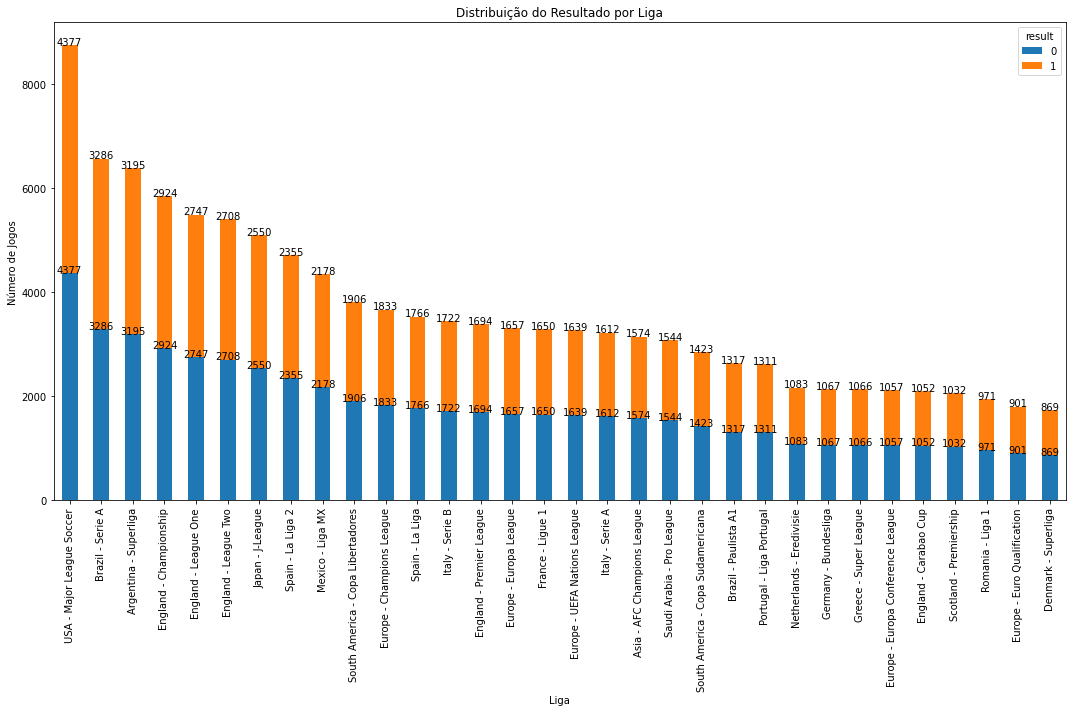

<Figure size 432x288 with 0 Axes>

In [41]:
# Função para filtrar ligas com base no número mínimo de partidas
def filter_leagues(df, league_col, matches, min_matches=100):
    # Agrupa o DataFrame por liga e conta o número único de partidas para cada liga
    league_game_counts = df.groupby(league_col)[matches].nunique()
    # Filtra para manter apenas as ligas com um número de partidas igual ou maior que min_matches
    leagues_filtered = league_game_counts[league_game_counts >= min_matches].index
    # Filtra o DataFrame original para incluir apenas linhas das ligas selecionadas
    filtered_data = df[df[league_col].isin(leagues_filtered)]
    return filtered_data

# Função para equilibrar o conjunto de dados com base na contagem de resultados em cada liga
def balance_data(df, league_col='league', result_col='result'):
    df = df.drop_duplicates()

    leagues = df[league_col].unique()
    # Lista para armazenar os DataFrames balanceados para cada liga
    balanced_dfs = []

    # Itera sobre cada liga para balancear os dados
    for league in leagues:
        # Filtra o DataFrame para incluir apenas dados da liga atual
        league_df = df[df[league_col] == league]

        # Conta o número de ocorrências de cada resultado na liga
        result_counts = league_df[result_col].value_counts()
        # Obtém o menor número de ocorrências entre os resultados
        min_count = result_counts.min()

        # Itera sobre os resultados únicos para balancear a quantidade de cada um
        for result in league_df[result_col].unique():
            # Define o tamanho da amostra com base no menor número de ocorrências
            sample_size = min(min_count, result_counts[result])
            # Coleta uma amostra aleatória de dados para o resultado atual
            sampled_df = league_df[league_df[result_col] == result].sample(sample_size, random_state=42)
            # Adiciona a amostra balanceada à lista
            balanced_dfs.append(sampled_df)

    # Combina todos os DataFrames balanceados em um único DataFrame
    balanced_data = pd.concat(balanced_dfs).reset_index(drop=True)

    return balanced_data



print("Contando partidas por time...")
total_matches_per_team = len(df['match_id'].unique())
print("Total de partidas:", total_matches_per_team)

print("\nFiltrando dados de ligas...")
filtered_data = filter_leagues(df, 'league', 'match_id')
print("Dados filtrados:\n")
print(filtered_data['league'].value_counts())

print("\nBalanceando dados...")
balanced_data = balance_data(filtered_data)
print("Dados balanceados:\n")
print(balanced_data['result'].value_counts())

league_distribution = balanced_data.groupby(['league', 'result']).size().unstack()
sorted_leagues = league_distribution.sum(axis=1).sort_values(ascending=False).head(100).index

print("Contando partidas depois dos filtros...")
total_matches_per_team = len(balanced_data['match_id'].unique())
print("Total de partidas:", total_matches_per_team)

plt.figure(figsize=(15, 10))
ax = league_distribution.loc[sorted_leagues].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribuição do Resultado por Liga')
plt.ylabel('Número de Jogos')
plt.xlabel('Liga')
plt.tight_layout()
plt.xticks(rotation=90)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0f}', (x + width/2, y + height), ha='center')

plt.show()
plt.clf()  

In [42]:
balanced_data

,minute,homeTeam,awayTeam,shotsHome,shotsAway,blockedShotsHome,blockedShotsAway,league,corners_home,corners_away,...,fouls_home,fouls_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id,possessiontime_away,possessiontime_home
0,30,CR Flamengo,SC Corinthians Paulista,2.0,5.0,0.0,2.0,South America - Copa Libertadores,1.0,1.0,...,3.0,4.0,0.0,0.0,3.0,7.0,0,2022-08-10-CR Flamengo-SC Corinthians Paulista,40.0,60.0
1,35,Clube Atlético Mineiro,SE Palmeiras,13.0,1.0,3.0,0.0,South America - Copa Libertadores,2.0,2.0,...,8.0,10.0,0.0,0.0,7.0,8.0,0,2022-08-04-Clube Atlético Mineiro-SE Palmeiras,47.0,53.0
2,40,Argentinos Juniors,CD Universidad Católica,3.0,1.0,1.0,1.0,South America - Copa Libertadores,1.0,1.0,...,5.0,5.0,1.0,0.0,1.0,9.0,0,2021-05-12-Argentinos Juniors-CD Universidad C...,50.0,50.0
3,16,CA River Plate,SE Palmeiras,3.0,1.0,1.0,0.0,South America - Copa Libertadores,2.0,0.0,...,2.0,3.0,0.0,0.0,1.0,4.0,0,2021-01-06-CA River Plate-SE Palmeiras,31.0,69.0
4,26,CSD Independiente del Valle,SE Palmeiras,2.0,1.0,1.0,0.0,South America - Copa Libertadores,1.0,1.0,...,3.0,1.0,0.0,5.0,1.0,2.0,0,2021-05-12-CSD Independiente del Valle-SE Palm...,34.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116127,31,Israel,Kosovo,5.0,1.0,0.0,0.0,Europe - Euro Qualification,1.0,1.0,...,4.0,3.0,0.0,1.0,7.0,9.0,1,2023-03-25-Israel-Kosovo,55.0,45.0
116128,44,Belarus,Kosovo,5.0,5.0,1.0,1.0,Europe - Euro Qualification,1.0,3.0,...,3.0,2.0,1.0,1.0,5.0,5.0,1,2023-06-19-Belarus-Kosovo,63.0,37.0
116129,38,Finland,Northern Ireland,3.0,4.0,1.0,1.0,Europe - Euro Qualification,2.0,1.0,...,2.0,7.0,1.0,0.0,3.0,9.0,1,2023-11-17-Finland-Northern Ireland,38.0,62.0
116130,45,Czechia,Albania,6.0,0.0,1.0,0.0,Europe - Euro Qualification,3.0,0.0,...,5.0,5.0,1.0,3.0,8.0,8.0,1,2023-09-07-Czechia-Albania,43.0,57.0


In [43]:
balanced_data.to_csv("data_balanced.csv", index=False, encoding='utf-8')

In [44]:
balanced_data.value_counts('result')

result
0    58066
1    58066
Name: count, dtype: int64